# Zeitfensteranalyse

## Einleitung

Ziel dieses Notebooks ist es eine Unterstützung zu bieten, um ein Zeitfenster zu bestimmen, in welchem Bewegungssensordaten    
zu einer Aufnahme erfasst werden. Zu diesen gehören die Beschleunigungssensordaten X,Y,Z sowie die Winkel Roll, Nick und Gier.   

## Herausforderungen

Bevor die Belichtung einer Aufnahme beginnt sollen bereits die Bewegungsdaten erfasst werden. Es gibt einen Handler in der Android   
Camera2 API, welcher beim Start der Belichtung aufgerufen wird. Wenn dann erst die Erfassung der Daten gestartet wird, dann    
wäre dies bereits zu spät. Da zu diesem Zeitpunkt die Belichtung bereits begonnen hat. Eine weitere Herausforderung ist ausreihend Datenwerte   
zu ermitteln. Ist die Datenerfassung zu kurz werden nur wenige bis keine Daten erfasst. Desweiteren ist der Zeitpunkt   
bei welchem die Datenerfassung gestoppt wird relevant.

In [1]:
import pandas
import pandas 
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import datetime

In [2]:
featuresDf = pandas.read_csv(filepath_or_buffer="features.csv")

In [3]:
featuresDf.describe()

,Zeitstempel,Breitengrad,Laengengrad,Geschwindigkeit,MittelWX,VarianzX,StandardAX,MittelWY,VarianzY,StandardAY,...,MittelWPitch,VarianzPitch,StandardAPitch,MittelWRoll,VarianzRoll,StandardRoll,StartBewegungsD,StartBelichtung,Belichtungszeit,StoppBewegungsD
count,5.374000e+03,5374.000000,5374.000000,5374.000000,5374.000000,5374.000000,5374.000000,5374.000000,5374.000000,5374.000000,...,5374.000000,5374.000000,5374.000000,5374.000000,5374.000000,5374.000000,5.374000e+03,5.374000e+03,5.374000e+03,5.374000e+03
mean,1.519222e+12,53.613946,10.161071,15.344702,-0.546871,38.949616,2.659251,0.407541,21.348658,2.229567,...,-0.019209,0.012089,0.037664,-0.053249,0.026076,0.030620,2.954125e+13,2.954132e+13,1.320892e+07,2.954075e+13
std,4.787940e+05,0.001040,0.013956,5.330909,5.904707,95.472608,5.646810,4.983187,49.756362,4.047569,...,0.356933,0.060331,0.102849,0.475262,0.350197,0.158223,4.787830e+11,4.787951e+11,5.567292e+06,4.787748e+11
min,1.519222e+12,53.610455,10.137818,0.000000,-23.218000,0.000000,0.000000,-31.113000,0.000000,0.000000,...,-1.476000,0.000000,0.000000,-3.199000,0.000000,0.000000,2.869522e+13,2.869515e+13,7.106086e+06,2.869527e+13
25%,1.519222e+12,53.613586,10.150167,12.708000,-1.853250,0.000000,0.000000,-1.358500,0.000000,0.000000,...,-0.114000,0.000000,0.000000,-0.098000,0.000000,0.000000,2.912483e+13,2.912476e+13,1.000184e+07,2.912476e+13
50%,1.519222e+12,53.613888,10.159737,16.164000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.954417e+13,2.954425e+13,1.000184e+07,2.954417e+13
75%,1.519223e+12,53.614555,10.173259,19.331999,0.748000,1.216750,1.103250,2.849500,9.134500,3.022750,...,0.111000,0.000000,0.000000,0.015000,0.000000,0.000000,2.995052e+13,2.995047e+13,2.000368e+07,2.995052e+13
max,1.519223e+12,53.615856,10.185248,26.280000,28.524000,554.584000,23.550000,36.337000,442.166000,21.028000,...,1.579000,1.254000,1.120000,3.065000,9.121000,3.021000,3.036319e+13,3.036313e+13,3.287369e+07,3.036319e+13


In [4]:
# Fügt eine Spalte mit dem Datum hinzu und eine mit der verstrichenen Zeit seit dem Start
# in Millisekunden
date = []
ms = []
for row in featuresDf.Zeitstempel:
    date.append(datetime.datetime.fromtimestamp(row/1000.0).strftime('%Y-%m-%d %H:%M:%S.%f'))
    ms.append(row - featuresDf.Zeitstempel[0])
featuresDf['Datum'] = date
featuresDf['Millisekunden'] = ms
featuresDf.head(5)

,Zeitstempel,Breitengrad,Laengengrad,Geschwindigkeit,MittelWX,VarianzX,StandardAX,MittelWY,VarianzY,StandardAY,...,StandardAPitch,MittelWRoll,VarianzRoll,StandardRoll,StartBewegungsD,StartBelichtung,Belichtungszeit,StoppBewegungsD,Datum,Millisekunden
0,1519221554869,53.61378,10.138174,0.0,0.002,0.416,0.645,-0.163,42.753,6.539,...,0.003,0.011,0.001,0.005,28695221273790,28695151826775,20003678,28695269322592,2018-02-21 14:59:14.869000,0
1,1519221555195,53.61378,10.138174,0.0,0.198,0.152,0.390,-3.468,45.429,6.741,...,0.000,-0.002,0.000,0.000,28695580181602,28695519306775,20003678,28695581130769,2018-02-21 14:59:15.195000,326
2,1519221555478,53.61378,10.138174,0.0,-0.082,0.059,0.243,0.328,35.754,5.980,...,0.001,0.002,0.001,0.001,28695852430248,28695786555775,20003678,28695859420144,2018-02-21 14:59:15.478000,609
3,1519221555767,53.61378,10.138174,0.0,-0.159,0.000,0.000,3.897,0.000,0.000,...,0.000,-0.007,0.000,0.000,28696152192748,28696087197775,20003678,28695859420144,2018-02-21 14:59:15.767000,898
4,1519221556039,53.61378,10.138174,0.0,-0.430,0.000,0.000,4.733,0.000,0.000,...,0.000,-0.026,0.000,0.000,28696420762644,28696354450775,20003678,28695859420144,2018-02-21 14:59:16.039000,1170


In [5]:
featuresDf.index

RangeIndex(start=0, stop=5374, step=1)

In [6]:
featuresDf.Belichtungszeit[featuresDf.Belichtungszeit < 1000]

Series([], Name: Belichtungszeit, dtype: int64)

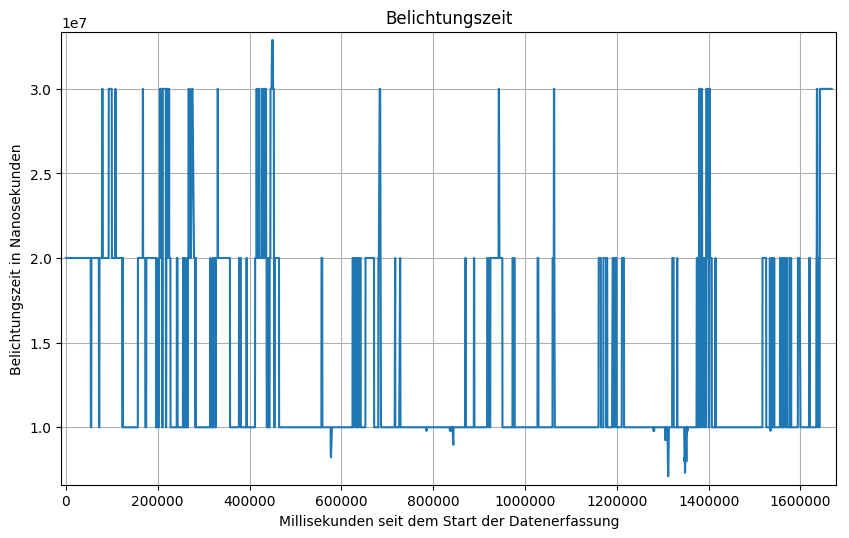

In [7]:
fig = plt.figure(num=None, figsize=(10, 6), dpi=100)
plt.title('Belichtungszeit')
plt.ylabel('Belichtungszeit in Nanosekunden')
plt.xlabel('Millisekunden seit dem Start der Datenerfassung')
plt.plot(featuresDf['Millisekunden'],featuresDf['Belichtungszeit'])
xOffset = 10000 # Für schönen Plot
yOffset = 500000 
plt.grid(True)
plt.xlim(-xOffset, featuresDf.iloc[-1,:].Millisekunden+xOffset)
plt.ylim(featuresDf.Belichtungszeit.min()-yOffset, featuresDf.Belichtungszeit.max()+yOffset)
plt.savefig("belichtungszeit.jpg")

In [8]:
startSensorDataCollectionDf = featuresDf.StartBewegungsD
startExposureDf = featuresDf.StartBelichtung

Die Funktion berechnet den Mittelwert der Differenz zwischen zwei Dataframes mit einer Spalte.   
Prec.: startDf und endDf haben jeweils eine Spalte. Anzahl der Reihen der Dataframes > 0   
Postc: Gibt den Mittelwert zurück   

In [9]:
def calcMeanTime(startDf,endDf):
    meanStartM = startDf.iloc[:].mean()
    meanStartE = endDf.iloc[:].mean()
    return meanStartM - meanStartE

In [10]:
calcMeanTime(startExposureDf,startSensorDataCollectionDf)

78833685.27734375

Berechnitt die maximale Differenz zwischen den Achsen von zwei Dataframes   
Prec.: startDf und endDf haben jeweils eine Spalte. Anzahl der Reihen der Dataframes > 0     
Postc.: Maximaler Wert

In [11]:
def calcMaxGap(endDf,startDf):
    maxDf = endDf - startDf
    return maxDf.max()

In [12]:
calcMaxGap(startExposureDf, startSensorDataCollectionDf)

3156587736

In [13]:
# Dataframe mit Startpunkten der Belichtungszeit einer Aufnahme addiert mit der jeweiligen Belichtungszeit
startExposurePlusExposureTime = featuresDf.StartBelichtung + featuresDf.Belichtungszeit
startExposurePlusExposureTime.head(2)

0    28695171830453
1    28695539310453
dtype: int64

In [14]:
# Mitteltert der belichtungszeit
featuresDf.Belichtungszeit.mean()

13208916.122627465

In [15]:
# Max Belichtungszeit
featuresDf.Belichtungszeit.max()

32873690

In [28]:
# Berechnet den Mittelwert der Differenzen zwischen Start der Belichtungszeit mit 
# Belichtungszeit und Stopp der Bewesungssensordatenerfassung
calcMeanTime(startExposurePlusExposureTime,featuresDf.StoppBewegungsD)

218974029.671875

In [25]:
# Gibt den Index zurück mit der Zeitdifferenz größer als der angegebene Grenzwert
diffDf = startExposurePlusExposureTime - featuresDf.StoppBewegungsD
diffDf[diffDf > 5000000000]
featuresDf.iloc[3709]

Zeitstempel                     1519222713098
Breitengrad                            53.614
Laengengrad                           10.1617
Geschwindigkeit                        17.064
MittelWX                              -10.911
VarianzX                                    0
StandardAX                                  0
MittelWY                                3.272
VarianzY                                    0
StandardAY                                  0
MittelWZ                               13.216
VarianzZ                                    0
StandardAZ                                  0
Azimuth                                     0
MittelWPitch                            0.192
VarianzPitch                                0
StandardAPitch                              0
MittelWRoll                             0.011
VarianzRoll                                 0
StandardRoll                                0
StartBewegungsD                29853477344650
StartBelichtung                298

In [29]:
diffDf.min()

-97492139

In [ ]:
calcMaxGap(startExposurePlusExposureTime, featuresDf.StoppBewegungsD)

In [ ]:
# Unittests
import unittest

class CalcTimeframeTest(unittest.TestCase):
    
    # Testet die Funktion calcMaxGap
    # Dabei wird mehere Datenwerte verwendet
    def testCalcMaxGap(self):
        dEnd = [10, 20, 5]
        dfEnd = pandas.DataFrame(dEnd)
        dStart = [2, 10, 1]
        dfStart = pandas.DataFrame(dStart)
        self.assertEqual(calcMaxGap(dfEnd,dfStart)[0], 10)
        
    # Testet die Funktion calcMaxGap
    # Dabei wird ein Datenwert genutzt
    def testCalcMaxGapOne(self):
        dEnd = [10]
        dfEnd = pandas.DataFrame(dEnd)
        dStart = [10]
        dfStart = pandas.DataFrame(dStart)
        self.assertEqual(calcMaxGap(dfEnd,dfStart)[0], 0)
        
    
    # Testet die Funktion calcMaxGap
    # Die Anzahl der Reihen ist unterschiedlich
    def testCalcMaxGapUnequal(self):
        dEnd = [10,20,20]
        dfEnd = pandas.DataFrame(dEnd)
        dStart = [10]
        dfStart = pandas.DataFrame(dStart)
        self.assertEqual(calcMaxGap(dfEnd,dfStart)[0], 0)
        
    # Dieser Test testet die Funktion calcMeanTime.
    # Hier wird die Mittlere Differenz gleich 0 erwartet
    def testCalcMeanTimeZero(self):
        dEnd = [10,10,10]
        dfEnd = pandas.DataFrame(dEnd)
        dStart = [10,10,10]
        dfStart = pandas.DataFrame(dStart)
        self.assertEqual(calcMeanTime(dfEnd,dfStart)[0], 0.0)
        
    # Dieser Test testet die Funktion calcMeanTime.
    # Hier wird die Mittlere Differenz gleich 0 erwartet
    def testCalcMeanTimeZero(self):
        dEnd = [10,10,10]
        dfEnd = pandas.DataFrame(dEnd)
        dStart = [10,10,10]
        dfStart = pandas.DataFrame(dStart)
        self.assertEqual(calcMeanTime(dfEnd,dfStart)[0], 0.0)
    
    # Test die Funktion calcMeanTime.
    # Es werden mehrere unterschiedliche Werte getestet
    def testCalcMeanTimeValues(self):
        dEnd = [4,8,3,5,60]
        dfEnd = pandas.DataFrame(dEnd)
        dStart = [4,3,10,40,3]
        dfStart = pandas.DataFrame(dStart)
        self.assertEqual(calcMeanTime(dfEnd,dfStart)[0], 4.0)        
  
    # Test die Funktion calcMeanTime.
    # Dabei sind die Anzahl der Reihen unterschiedlich
    def testCalcMeanTimeUnequal(self):
        dEnd = [4,8,3,5,60]
        dfEnd = pandas.DataFrame(dEnd)
        dStart = [4,6,10,40]
        dfStart = pandas.DataFrame(dStart)
        self.assertEqual(calcMeanTime(dfEnd,dfStart)[0], 1.0)        

unittest.main(argv=[''], verbosity=2, exit=False)